<a href="https://colab.research.google.com/github/andrea-prodon/Phishing-Website-Detector/blob/main/Phishing_Website_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Phishing Website Detector**

In this project I will try to classify websites as safe or risky, evaluating the probability of a certain website to be a phishing website, that is a fake website with the malignant intent of extortion of personal information, financial data or access codes by hackers.

For the sake of this purpose, I will be using a dataset from [Kaggle](https://www.kaggle.com/aman9d/phishing-data) that contains information about 95910 websites.

Each record (**x**, _y_) contains website information represented by means of **12 features** (i.e., **x** = _x1_, ..., _x12_), along with a **binary response** (_y_), which indicates whether the website is a phishing one (_y_ = 1) or not (_y_ = 0).

The classification goal is, given a website, to predict if it will be a phishing or a real website.

If something goes wrong in the execution of the whole notebook, please restart runtime and re-execute the following sections:
- setting up pyspark
- import libraries
- importing the dataset
- dataset pre-processing functions
- feature extractor (if the section that went wrong is related to the phishing detection tool)

and then re-execute the section that went wrong.
This can happen due to limited java heap space mainly consumed by decision tree and random forest

In [2]:
# @title **Setting up PySpark**
%%capture
import os
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop2.7.tgz
!tar -xvf spark-3.1.1-bin-hadoop2.7.tgz
!pip install -q findspark
import findspark
!pip install pyspark
from pyspark.sql import SparkSession
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop2.7"
findspark.init()
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark

In [3]:
# @title **Import Libraries**

import numpy as np
import pandas as pd
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf, StringType
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier, LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier,  LinearSVC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics
import re


import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf


# **Importing the Dataset**

**Dataset Description**

- Domain: The URL itself.
- Ranking: Page Ranking
- isIp: Is there an IP address in the weblink
- valid: This data is fetched from google's whois API that tells us more about the current status of the URL's registration.
- activeDuration: Also from whois API. Gives the duration of the time since the registration up until now.
- urlLen: It is simply the length of the URL
- is@: If the link has a '@' character then it's value = 1
- isredirect: If the link has double dashes, there is a chance that it is a redirect. 1-> multiple dashes present together.
- haveDash: If there are any dashes in the domain name.
- domainLen: The length of just the domain name.
- noOfSubdomain: The number of subdomains preset in the URL.
- Labels: 0 -> Legitimate website , 1 -> Phishing Link/ Spam Link

In [4]:
# @title **Downloading Dataset**
url = 'https://raw.githubusercontent.com/andrea-prodon/PhishingWebsiteDetector/main/combined_dataset.csv'
phishing_pdf = pd.read_csv(url)
phishing_data = spark.createDataFrame(phishing_pdf)

In [5]:
print("The shape of the dataset is {:d} rows by {:d} columns".format(phishing_data.count(), len(phishing_data.columns)))

The shape of the dataset is 95910 rows by 12 columns


In [6]:
#define utility constants

CATEGORICAL_FEATURES = ["domain"]

NUMERICAL_FEATURES = ["ranking", "isIp", "valid", "activeDuration", "urlLen", "is@", "isredirect", "haveDash", "domainLen", "nosOfSubdomain"]

TARGET_VARIABLE = "label"

# **Exploring the Dataset**

In [6]:
phishing_data.show(10, truncate = True)   #show some dataset rows

+--------------------+--------+----+-----+--------------+------+---+----------+--------+---------+--------------+-----+
|              domain| ranking|isIp|valid|activeDuration|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|
+--------------------+--------+----+-----+--------------+------+---+----------+--------+---------+--------------+-----+
|www.voting-yahoo.com|10000000|   0|    0|             0|    20|  0|         0|       1|       20|             2|    1|
|www.zvon.org/xxl/...|  194914|   0|    1|          7305|    42|  0|         0|       0|       12|             2|    0|
|tecportais.com/fi...|10000000|   0|    0|             0|   155|  0|         0|       0|       14|             1|    1|
|bima.astro.umd.ed...|    7001|   0|    0|             0|    35|  0|         0|       0|       18|             3|    0|
|huarui-tec.com/js...|10000000|   0|    1|           730|    79|  0|         0|       1|       14|             1|    1|
|diannaopeizhi.com...|10000000|   0|    

In [7]:
phishing_data.printSchema()   #show dataset schema

root
 |-- domain: string (nullable = true)
 |-- ranking: long (nullable = true)
 |-- isIp: long (nullable = true)
 |-- valid: long (nullable = true)
 |-- activeDuration: long (nullable = true)
 |-- urlLen: long (nullable = true)
 |-- is@: long (nullable = true)
 |-- isredirect: long (nullable = true)
 |-- haveDash: long (nullable = true)
 |-- domainLen: long (nullable = true)
 |-- nosOfSubdomain: long (nullable = true)
 |-- label: long (nullable = true)



In [8]:
phishing_data.describe().toPandas().transpose()    

,0,1,2,3,4
summary,count,mean,stddev,min,max
domain,95910,None,None,00.124.324.77.00.opteamevent.hu/,zzzinn.com/www.paypal.co.il/israel/06282818e09...
ranking,95910,6118618.437576895,4835253.573402703,1,10000000
isIp,95910,2.29381712021687E-4,0.015143694633846785,0,1
valid,95910,0.5738921905953498,0.4945123799026841,0,1
activeDuration,95910,3747.87614430195,3974.5871882361776,0,15707
urlLen,95910,69.32744239391096,69.740134243066,9,2175
is@,95910,0.0027734334271713066,0.05259059166180571,0,1
isredirect,95910,0.007444479199249296,0.08596008359171643,0,1
haveDash,95910,0.1578563236367428,0.36460813321466534,0,1


In [9]:
phishing_pdf = phishing_data.toPandas()   # creating pandas dataframe from spark dataframe to plot following charts

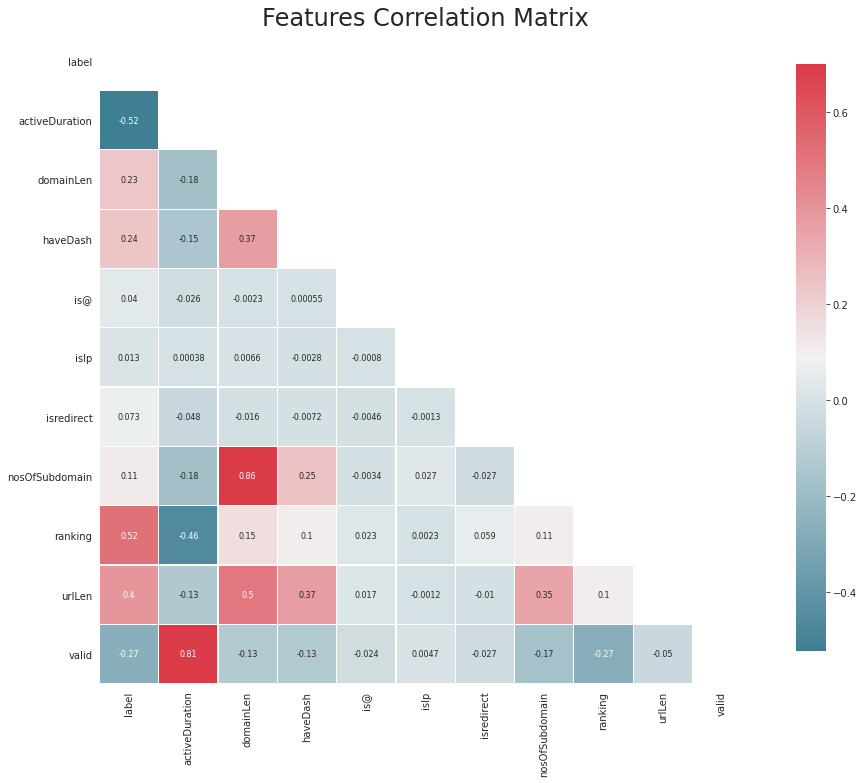

In [10]:
#plot correlation matrix chart

features = [TARGET_VARIABLE] + sorted(NUMERICAL_FEATURES + CATEGORICAL_FEATURES)

mask = np.zeros_like(phishing_pdf[features].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

with sns.axes_style("white"):
  fig, ax = plt.subplots(figsize=(16, 12))
  plt.title('Features Correlation Matrix', fontsize=24)

  cmap = sns.diverging_palette(220, 10, as_cmap=True)

  _ = sns.heatmap(phishing_pdf[features].corr(), 
              linewidths=0.25, 
              vmax=0.7, 
              square=True,
              ax=ax, 
              cmap=cmap, 
              linecolor='w', 
              annot=True, 
              annot_kws={"size":8}, 
              mask=mask, 
              cbar_kws={"shrink": .9});

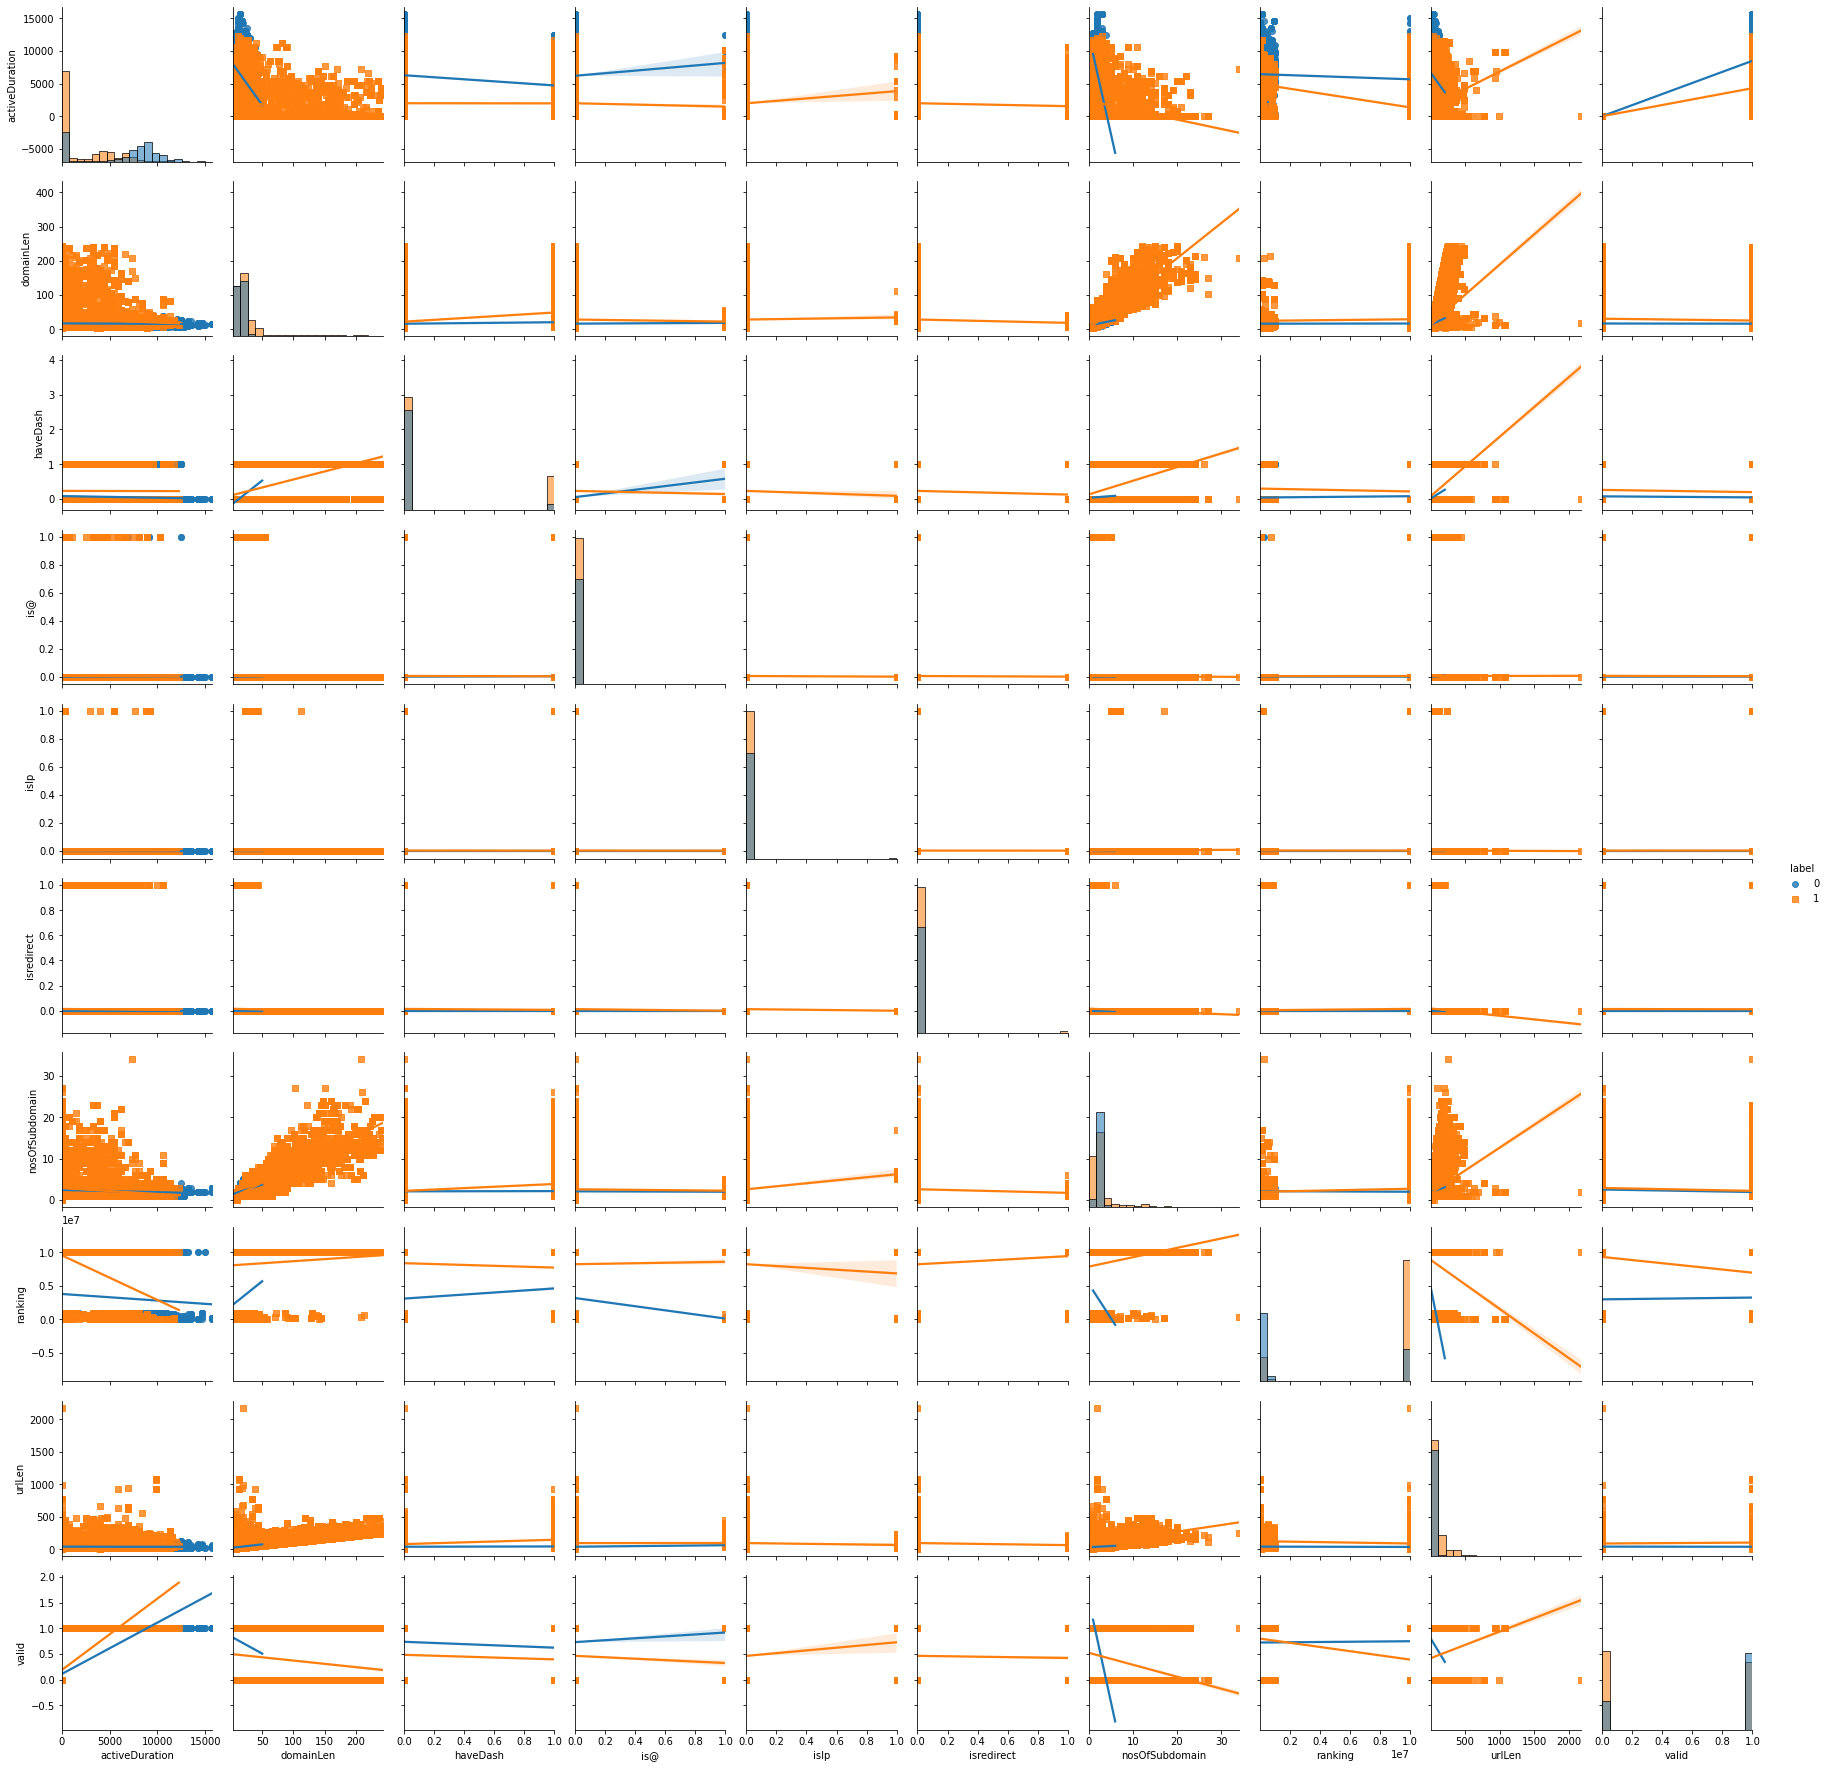

In [11]:
# plot the pairwise relationship between each numerical feature
# this will take several minutes (5-6)

_ = sns.pairplot(data=phishing_pdf, 
                 vars=sorted(NUMERICAL_FEATURES), 
                 hue=TARGET_VARIABLE, 
                 kind="reg",
                 diag_kind='hist',
                 diag_kws = {'alpha':0.55, 'bins':20},
                 markers=["o", "s"]
                )

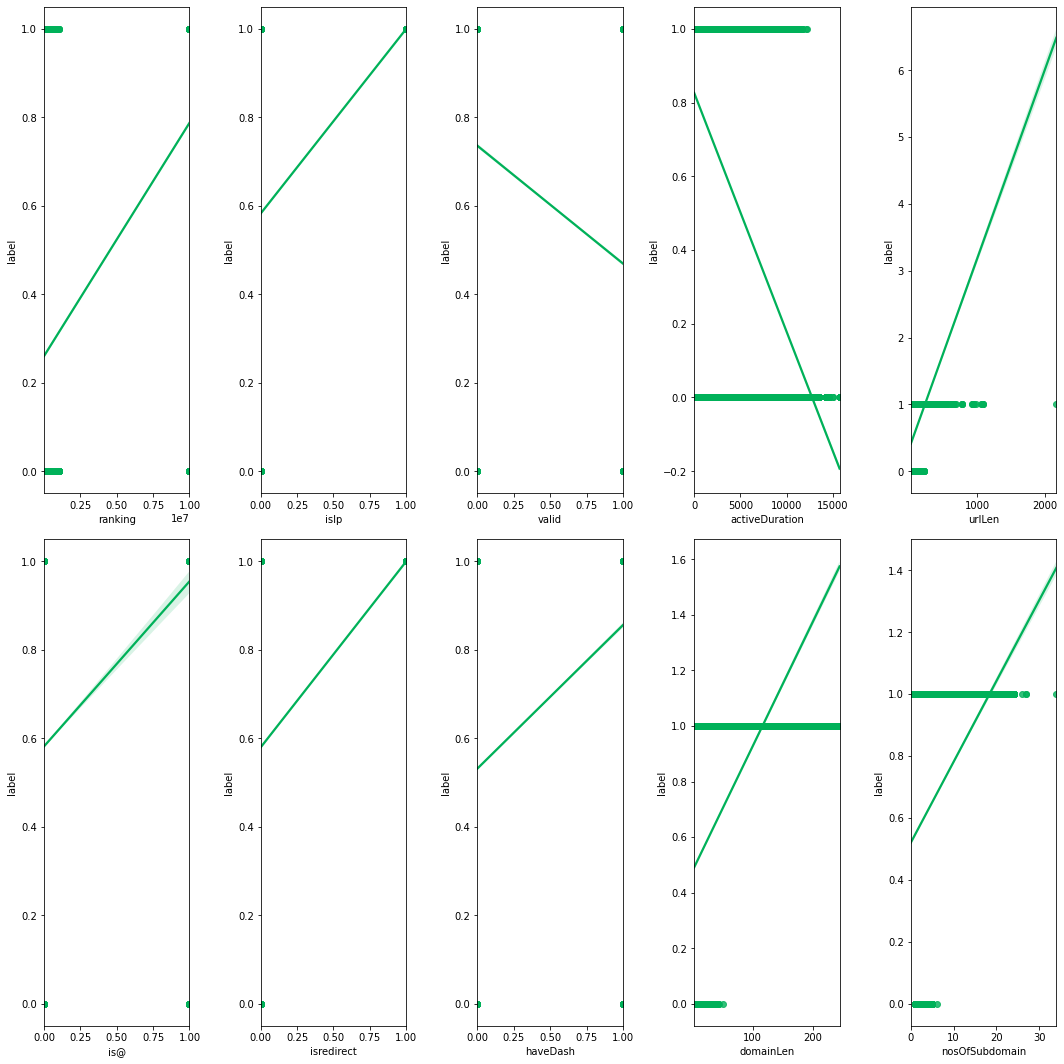

In [12]:
# show correlation between each feature and target label

n_rows = 2
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,15))

for i,f in enumerate(NUMERICAL_FEATURES):
  _ = sns.regplot(data=phishing_pdf, 
                  x=f, 
                  y="label",
                  color="#00b159",
                  ax=axes[i//n_cols, i%n_cols])

fig.tight_layout(pad=1.5)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

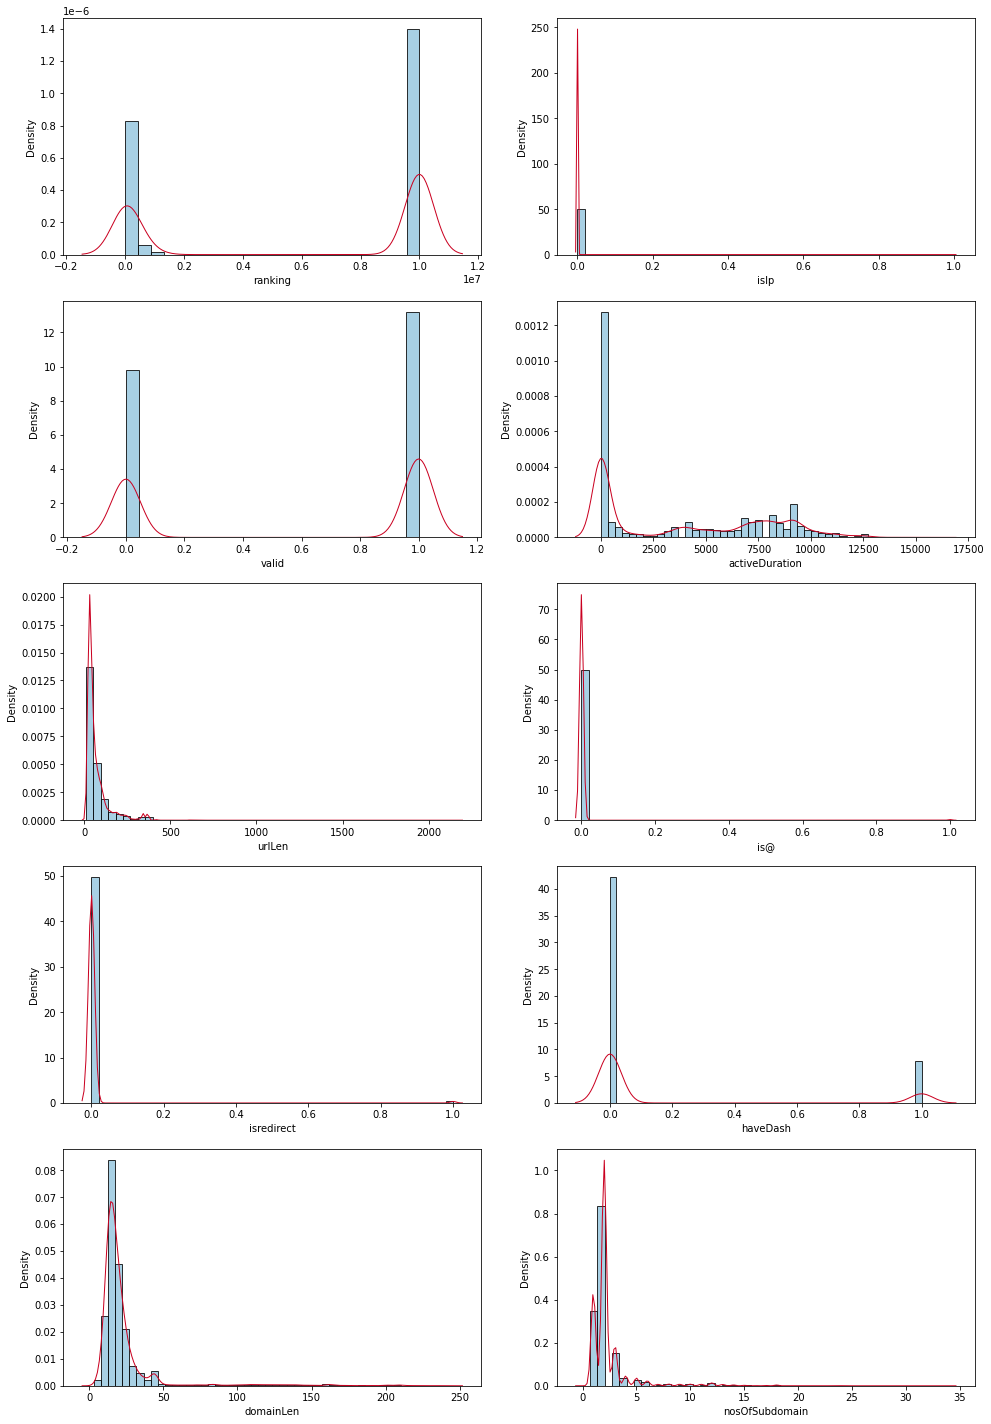

In [13]:
# Plot the distribution of values of each feature column 

n_rows = 5
n_cols = 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14,20))

for i,f in enumerate(NUMERICAL_FEATURES):
    _ = sns.distplot(phishing_pdf[f],
                    kde_kws={"color": "#ca0020", "lw": 1}, 
                    hist_kws={"histtype": "bar", "edgecolor": "k", "linewidth": 1,"alpha": 0.8, "color": "#92c5de"},
                    ax=axes[i//n_cols, i%n_cols]
                    )

fig.tight_layout(pad=1.5)

In [14]:
#show label count (the dataset is balanced)

phishing_data.groupBy(TARGET_VARIABLE).count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|39996|
|    1|55914|
+-----+-----+



**Observations**

From the previous charts we can notice that most of the features are not correlated, since they just describe some textual characteristics of the URL.
For instance, the fact that the URL contains a "@" is of course not correlated to the fact it contains a "-".
The only feature correlated are the length of the url and the length of the domain name or the number of subdomains, since the contribute to the total length of the URL

# **Data Pre-processing functions**

In [7]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [8]:
#function to transform categorical features into numerical, and create features and label column to feed learning models

def to_numerical(df, numerical_features, categorical_features, target_variable):

    indexers = [StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c), handleInvalid="keep") for c in categorical_features]

    encoder = OneHotEncoder(inputCols=[indexer.getOutputCol() for indexer in indexers], 
                                    outputCols=["{0}_encoded".format(indexer.getOutputCol()) for indexer in indexers], 
                                    handleInvalid="keep")

    label_indexer = StringIndexer(inputCol = target_variable, outputCol = "targ_label", stringOrderType="frequencyAsc")
    
    assembler = VectorAssembler(inputCols=encoder.getOutputCols() + numerical_features, outputCol="features")

    stages = indexers + [encoder] + [label_indexer] + [assembler]

    pipeline = Pipeline(stages=stages)

    transformer = pipeline.fit(df)
    df_transformed = transformer.transform(df)

    return transformer, df_transformed 

In [9]:
#transform train set

oh_transformer, transformed_train_df = to_numerical(train, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
train = transformed_train_df.select(["features", "targ_label"])

In [10]:
#transform test set

transformed_test_df = oh_transformer.transform(test)
test = transformed_test_df.select(["features", "targ_label"])

In [11]:
train.show(10, truncate=False)
test.show(10, truncate=False)

+-------------------------------------------------------------------------------------------------+----------+
|features                                                                                         |targ_label|
+-------------------------------------------------------------------------------------------------+----------+
|(60971,[14308,60961,60962,60965,60969,60970],[1.0,1.0E7,1.0,32.0,31.0,6.0])                      |1.0       |
|(60971,[14310,60961,60963,60964,60965,60969,60970],[1.0,1.0E7,1.0,6210.0,113.0,20.0,2.0])        |1.0       |
|(60971,[14312,60961,60963,60964,60965,60969,60970],[1.0,26078.0,1.0,4018.0,47.0,22.0,2.0])       |1.0       |
|(60971,[14313,60961,60963,60964,60965,60969,60970],[1.0,33380.0,1.0,4383.0,44.0,23.0,2.0])       |1.0       |
|(60971,[14315,60961,60965,60969,60970],[1.0,1.0E7,14.0,13.0,1.0])                                |1.0       |
|(60971,[1507,60961,60963,60964,60965,60969,60970],[1.0,87267.0,1.0,3288.0,45.0,15.0,2.0])        |1.0       |
|

# **Logistic Regression**

**Defining and Training the Model**

In [20]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [21]:
indexers = [StringIndexer(handleInvalid='keep',inputCol=column, outputCol='{0}_index'.format(
    column)) for column in CATEGORICAL_FEATURES]

featuresCreator = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers] + NUMERICAL_FEATURES,
    outputCol='features')

In [22]:
#instantiate and fit a logistic regression model and add it to pipeline

log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)

pipeline = Pipeline(stages=indexers + [featuresCreator, log_reg])

#fit the pipeline on training set

log_reg_model = pipeline.fit(train)

In [23]:
# transform training set accordingly to the trained model

train_output = log_reg_model.transform(train)    
train_prediction = train_output.select(['label', 'prediction'])

In [24]:
#print training set evaluation metrics

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_output)))

Train weightedPrecision = 0.8802666338082169
Train weightedRecall = 0.880342547764069
Train accuracy = 0.880342547764069
Train f1 = 0.8803010693739968


**Testing the Model**

In [25]:
# transform test set accordinly to the trained model

test_output = log_reg_model.transform(test)    
test_prediction = test_output.select(['label', 'prediction'])

In [26]:
# print test set evaluation metrics

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_output)))

Test weightedPrecision = 0.8780823988364463
Test weightedRecall = 0.8714480444584252
Test accuracy = 0.871448044458425
Test f1 = 0.8721744657794398


# **Multi-Layer Perceptron**

Defining and Training the Model

In [27]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [28]:
#prepare data to fit mlp

indexers = [StringIndexer(handleInvalid='keep',inputCol=column, outputCol='{0}_index'.format(
    column)) for column in CATEGORICAL_FEATURES]

featuresCreator = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers] + NUMERICAL_FEATURES,
    outputCol='features')


In [29]:
#define an mlp model and add it to a pipeline

layers = [len(featuresCreator.getInputCols()), 8, 4, 4, 2]    #define mlp layers


mlp = MultilayerPerceptronClassifier(labelCol='label',
                                     featuresCol='features',
                                     maxIter = 100,
                                     layers = layers,
                                     blockSize = 128,
                                     seed = 42)

pipeline = Pipeline(stages=indexers + [featuresCreator, mlp])

In [30]:
#train the model fitting the pipeline with the training set

mlp_model = pipeline.fit(train)

In [31]:
#transform train set with trained model

train_output = mlp_model.transform(train)
train_prediction = train_output.select('prediction', 'label')

In [32]:
#transform test set with trained model

test_output = mlp_model.transform(test)
test_prediction = test_output.select('prediction', 'label')

In [33]:
#print offline evaluation metrics to evaluate the model basing on train set results

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_prediction)))

Train weightedPrecision = 0.7271588297223364
Train weightedRecall = 0.7119449216513092
Train accuracy = 0.7119449216513093
Train f1 = 0.6906631444048555


In [34]:
#print offline evaluation metrics to evaluate the model basing on test set results

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(test_prediction)))

Test weightedPrecision = 0.7397693401844512
Test weightedRecall = 0.7369717940652197
Test accuracy = 0.7369717940652196
Test f1 = 0.72863432135931


# **Decision Tree**

In [35]:
#re-take data in order to continue running the notebook without errors

train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [36]:
transformer, train_df = to_numerical(train, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
train = train_df.select(["features", "targ_label"])

In [37]:
test_df = transformer.transform(test)
test = test_df.select(["features", "targ_label"])

In [38]:
#define and fit a decision tree classifier learning model

dt = DecisionTreeClassifier(maxDepth=5, labelCol="targ_label", leafCol="leafId")
dt_model = dt.fit(train)

In [39]:
#use trained model to transform train and test set and print performance evaluation

train_output = dt_model.transform(train)
test_output = dt_model.transform(test)


# **Random Forest**

In [40]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [41]:
transformer, train_df = to_numerical(train, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
train = train_df.select(["features", "targ_label"])

In [42]:
test_df = transformer.transform(test)
test = test_df.select(["features", "targ_label"])

In [43]:
#define and fit a random forest classifier learning model

rf = RandomForestClassifier(labelCol="targ_label", featuresCol="features", numTrees=10)
rf_model = rf.fit(train)

In [44]:
#transform training and test set accordingly to trained model

train_output = rf_model.transform(train)
test_output = rf_model.transform(test)

# **Linear Support Vector Machine**

**Defining and Training the Model**

In [45]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [46]:
indexers = [StringIndexer(handleInvalid='keep',inputCol=column, outputCol='{0}_index'.format(
    column)) for column in CATEGORICAL_FEATURES]

featuresCreator = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers] + NUMERICAL_FEATURES,
    outputCol='features')

In [47]:
#instantiate and fit a lsvm model

lsvc = LinearSVC(maxIter=10, regParam=0.1).setLabelCol('label')

pipeline = Pipeline(stages=indexers + [featuresCreator, lsvc])

lsvc_model = pipeline.fit(train)

In [48]:
 # transform training set accordingly to the trained model

train_output = lsvc_model.transform(train)   
train_prediction = train_output.select(['label', 'prediction'])

In [49]:
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_output)))

Train weightedPrecision = 0.8237207752796014
Train weightedRecall = 0.8241709615284503
Train accuracy = 0.8241709615284502
Train f1 = 0.8227909164817329


**Testing the Model**

In [50]:
#transform test set with the trained model

test_output = lsvc_model.transform(test)     

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_output)))

Train weightedPrecision = 0.8237207752796014
Train weightedRecall = 0.8241709615284503
Train accuracy = 0.8241709615284502
Train f1 = 0.8227909164817329


# **Feature Extractor**

In [12]:
#function that, given a url, extract all features from it, creating a spark row dataframe that can be transformed by the trained model
#some of the features could not be extracted due to complications with the way they were acquired by the dataset

def feat_ext(url):
  
  #domain
  domain = url
  
  #isIp
  isIp = None
  result = re.findall(r'\b(?:(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\.){3}(?:25[0-5]|2[0-4][0-9]|[01]?[0-9][0-9]?)\b', url)
  if result:
    isIp = 1
  else:
    isIp = 0

  #urlLen
  urlLen = len(url)
  
  #is@
  is_hat = None
  result = re.findall(r'@', url)
  if result:
    is_hat = 1
  else:
    is_hat = 0

  #isRedirect
  isRedirect = None
  result = re.findall(r'\/\/', url)
  if result:
    isRedirect = 1
  else:
    isRedirect = 0
  
  #haveDash
  haveDash = None
  domain_name = re.findall(r'^(?:https?:\/\/)?(?:[^@\n]+@)?(?:www\.)?([^:\/\n?]+)', url)
  domain_name = domain_name[0]
  result = re.findall(r'-', domain_name)
  if result:
    haveDash = 1
  else:
    haveDash = 0
  
  #domainLen
  domainLen = len(domain_name)
  haveWWW = re.findall(r'www.', url)
  if haveWWW:
    domainLen += 4
    domain_name = 'www.' + domain_name
  

  #noOfSubdomain
  pattern=r'(?:\/\/)(\w+)|(?<=\.)(\w+)'
  result=[]
  match=re.finditer(pattern,domain_name)
  for i in match:
      if i.group(1)!=None:
          result.append(i.group(1))
      elif i.group(2)!=None and i.group(2)!='html':
          result.append(i.group(2))
  noOfSubdomain = len(result)

  row = [[domain, isIp, urlLen, is_hat, isRedirect, haveDash, domainLen, noOfSubdomain, 0]]     #label is 0 by default since we are only interested in the prediction
  
  df = pd.DataFrame(row, columns=['domain','isIp','urlLen','is@','isredirect','haveDash','domainLen','nosOfSubdomain','label']) 
  row_df = spark.createDataFrame(df) 

  return row_df


In [13]:
row = feat_ext("huarui-tec.com/js/?us.battle.net/login/en/?ref=gofcuyeus.battle.net/d3/en/index")
row.show()

+--------------------+----+------+---+----------+--------+---------+--------------+-----+
|              domain|isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|
+--------------------+----+------+---+----------+--------+---------+--------------+-----+
|huarui-tec.com/js...|   0|    79|  0|         0|       1|       14|             1|    0|
+--------------------+----+------+---+----------+--------+---------+--------------+-----+



# **Phishing Detection Tool Logistic Regression**


In [53]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [54]:
#re-define these constants removing the features I could not extract, so that the model will be able to fit the row dataframe

CATEGORICAL_FEATURES = ["domain"]

NUMERICAL_FEATURES = ["isIp", "urlLen", "is@", "isredirect", "haveDash", "domainLen", "nosOfSubdomain"]

TARGET_VARIABLE = "label"

In [55]:
indexers = [StringIndexer(handleInvalid='keep',inputCol=column, outputCol='{0}_index'.format(
    column)) for column in CATEGORICAL_FEATURES]

featuresCreator = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers] + NUMERICAL_FEATURES,
    outputCol='features')

In [56]:
#instantiate and fit a logistic regression model pipeline

log_reg = LogisticRegression(featuresCol = "features", labelCol = "label", maxIter=100)

pipeline = Pipeline(stages=indexers + [featuresCreator, log_reg])

log_reg_model = pipeline.fit(train)

In [57]:
#transform train set with trained model
train_output = log_reg_model.transform(train)
train_prediction = train_output.select('prediction', 'label')

#transform test set with trained model
test_output = log_reg_model.transform(test)
test_prediction = test_output.select('prediction', 'label')

#print offline evaluation metrics to evaluate the model basing on train set results
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_prediction)))

#print offline evaluation metrics to evaluate the model basing on test set results
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy',  'f1']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(
        test_prediction)))

Train weightedPrecision = 0.7864560417294527
Train weightedRecall = 0.7834608777135718
Train accuracy = 0.7834608777135718
Train f1 = 0.7843331016023962
Test weightedPrecision = 0.7923552031889307
Test weightedRecall = 0.7706301772045717
Test accuracy = 0.7706301772045717
Test f1 = 0.7717914642524815


In [58]:
#run the feature extraction function with a PHISHING url external to the dataset

url = '1\1\3124goog\23443543---òùèòàù+òà---@///??w5689u-4-534---::....\\\\953405@@d@@3485y/////777----le.cfgerogerg456378m.fgserg.drgesrg.erges.rgerg.erg'
row = feat_ext(url)

log_reg_pred = log_reg_model.transform(row)
log_reg_pred.show(truncate=False)
phish = log_reg_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")
  
prob = log_reg_pred.select(['probability'])

probability_safe = prob.head().probability[0]
probability_phish = prob.head().probability[1]

print('This website is', np.round(probability_phish, 3) * 100, '% a phishing website and', np.round(probability_safe, 3) * 100, '% a safe website') 

+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------------------------------+--------------------------------------+------------------------------------------+----------+
|domain                                                                                                                                   |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_index|features                                |rawPrediction                         |probability                               |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------------------------------+--------------------------------

In [59]:
#run the feature extraction function with a SAFE url external to the dataset

url = 'www.github.com/gtolomei/big-data-computing'
row = feat_ext(url)

log_reg_pred = log_reg_model.transform(row)
log_reg_pred.show(truncate=False)
phish = log_reg_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")
  
prob = log_reg_pred.select(['probability'])

probability_safe = prob.head().probability[0]
probability_phish = prob.head().probability[1]

print('This website is', np.round(probability_phish, 3) * 100, '% a phishing website and', np.round(probability_safe, 3) * 100, '% a safe website') 

+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+-------------------------------------+----------------------------------------+----------------------------------------+----------+
|domain                                    |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_index|features                             |rawPrediction                           |probability                             |prediction|
+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+-------------------------------------+----------------------------------------+----------------------------------------+----------+
|www.github.com/gtolomei/big-data-computing|0   |42    |0  |0         |0       |14       |2             |0    |60960.0     |(8,[0,2,6,7],[60960.0,42.0,14.0,2.0])|[1.2410007626805593,-1.2410007626805593]|[0.7757381634583191,0.2242618

# **Phishing Detection Tool MLP**

In [60]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [61]:
#re-define these constants removing the features I could not extract, so that the model will be able to fit the row dataframe

CATEGORICAL_FEATURES = ["domain"]

NUMERICAL_FEATURES = ["isIp", "urlLen", "is@", "isredirect", "haveDash", "domainLen", "nosOfSubdomain"]

TARGET_VARIABLE = "label"

In [62]:
#prepare data to fit mlp

indexers = [StringIndexer(handleInvalid='keep',inputCol=column, outputCol='{0}_index'.format(
    column)) for column in CATEGORICAL_FEATURES]

featuresCreator = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers] + NUMERICAL_FEATURES,
    outputCol='features')


In [63]:
#define an mlp model and add it to a pipeline
layers = [len(featuresCreator.getInputCols()), 8, 6, 4, 2]    #define mlp layers


mlp = MultilayerPerceptronClassifier(labelCol='label',
                                     featuresCol='features',
                                     maxIter = 100,
                                     layers = layers,
                                     blockSize = 128,
                                     seed = 42)

pipeline = Pipeline(stages=indexers + [featuresCreator, mlp])

In [64]:
#train the model fitting the pipeline with the training set
mlp_model = pipeline.fit(train)

In [65]:
#transform train set with trained model
train_output = mlp_model.transform(train)
train_prediction = train_output.select('prediction', 'label')

In [66]:
#transform test set with trained model
test_output = mlp_model.transform(test)
test_prediction = test_output.select('prediction', 'label')

In [67]:
#print offline evaluation metrics to evaluate the model basing on train set results
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_prediction)))

Train weightedPrecision = 0.7254556519928578
Train weightedRecall = 0.7116455827997293
Train accuracy = 0.7116455827997293
Train f1 = 0.6910919730105621


In [68]:
#print offline evaluation metrics to evaluate the model basing on test set results

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy',  'f1']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(
        test_prediction)))

Test weightedPrecision = 0.7471935615502163
Test weightedRecall = 0.7171542413756946
Test accuracy = 0.7171542413756946
Test f1 = 0.7178183309451325


In [69]:
#run the feature extraction function with a PHISHING url external to the dataset

url = '1\1\3124goog\23443543---òùèòàù+òà---@///??w5689u-4-534---::....\\\\953405@@d@@3485y/////777----le.cfgerogerg456378m.fgserg.drgesrg.erges.rgerg.erg'
row = feat_ext(url)

mlp_pred = mlp_model.transform(row)
mlp_pred.show(truncate=False)
phish = mlp_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")
  
prob = mlp_pred.select(['probability'])

probability_safe = prob.head().probability[0]
probability_phish = prob.head().probability[1]

print('This website is', np.round(probability_phish, 3) * 100, '% a phishing website and', np.round(probability_safe, 3) * 100, '% a safe website') 

+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------------------------------+-----------------------------------------+---------------------------------------+----------+
|domain                                                                                                                                   |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_index|features                                |rawPrediction                            |probability                            |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------------------------------+--------------------------------

In [70]:
#run the feature extraction function with a SAFE url external to the dataset

url = 'www.github.com/gtolomei/big-data-computing'
row = feat_ext(url)

mlp_pred = mlp_model.transform(row)
mlp_pred.show(truncate=False)
phish = mlp_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")
  
prob = mlp_pred.select(['probability'])

probability_safe = prob.head().probability[0]
probability_phish = prob.head().probability[1]

print('This website is', np.round(probability_phish, 3) * 100, '% a phishing website and', np.round(probability_safe, 3) * 100, '% a safe website') 

+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+-------------------------------------+-----------------------------------------+---------------------------------------+----------+
|domain                                    |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_index|features                             |rawPrediction                            |probability                            |prediction|
+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+-------------------------------------+-----------------------------------------+---------------------------------------+----------+
|www.github.com/gtolomei/big-data-computing|0   |42    |0  |0         |0       |14       |2             |0    |60960.0     |(8,[0,2,6,7],[60960.0,42.0,14.0,2.0])|[0.35060779698127487,-0.9663876849594324]|[0.7886813986961626,0.211318

# **Phishing Detection Tool Linear Support Vector Machine**

In [71]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [72]:
#re-define these constants removing the features I could not extract, so that the model will be able to fit the row dataframe

CATEGORICAL_FEATURES = ["domain"]

NUMERICAL_FEATURES = ["isIp", "urlLen", "is@", "isredirect", "haveDash", "domainLen", "nosOfSubdomain"]

TARGET_VARIABLE = "label"

In [73]:
indexers = [StringIndexer(handleInvalid='keep',inputCol=column, outputCol='{0}_index'.format(
    column)) for column in CATEGORICAL_FEATURES]

featuresCreator = VectorAssembler(
    inputCols=[indexer.getOutputCol() for indexer in indexers] + NUMERICAL_FEATURES,
    outputCol='features')

In [74]:
#instantiate and fit a lsvc  model

lsvc = LinearSVC(maxIter=10, regParam=0.1).setLabelCol('label')

pipeline = Pipeline(stages=indexers + [featuresCreator, lsvc])

lsvc_model = pipeline.fit(train)

In [75]:
#transform train set with trained model
train_output = lsvc_model.transform(train)
train_prediction = train_output.select('prediction', 'label')

#transform test set with trained model
test_output = lsvc_model.transform(test)
test_prediction = test_output.select('prediction', 'label')

#print offline evaluation metrics to evaluate the model basing on train set results
metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric)
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_prediction)))

#print offline evaluation metrics to evaluate the model basing on test set results

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy',  'f1']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric)
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(
        test_prediction)))

Train weightedPrecision = 0.694881322193967
Train weightedRecall = 0.6979931282211463
Train accuracy = 0.6979931282211463
Train f1 = 0.6951067205046368
Test weightedPrecision = 0.7387548507676172
Test weightedRecall = 0.6573870189787145
Test accuracy = 0.6573870189787144
Test f1 = 0.6480949544522561


In [76]:
#run the feature extraction function with a PHISHING url external to the dataset

url = '1\1\3124goog\23443543---òùèòàù+òà---@///??w5689u-4-534---::....\\\\953405@@d@@3485y/////777----le.cfgerogerg456378m.fgserg.drgesrg.erges.rgerg.erg'
row = feat_ext(url)

lsvc_pred = lsvc_model.transform(row)
lsvc_pred.show(truncate=False)
phish = lsvc_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")
  

+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------------------------------+--------------------------------------+----------+
|domain                                                                                                                                   |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_index|features                                |rawPrediction                         |prediction|
+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------------------------------+--------------------------------------+----------+
|1Ê4goog43543---òùèòàù+òà---@///??w5689u-4-534---::....\\953405@@

In [77]:
#run the feature extraction function with a SAFE url external to the dataset

url = 'www.github.com/gtolomei/big-data-computing'
row = feat_ext(url)

lsvc_pred = lsvc_model.transform(row)
lsvc_pred.show(truncate=False)
phish = lsvc_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")
  

+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+-------------------------------------+----------------------------------------+----------+
|domain                                    |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_index|features                             |rawPrediction                           |prediction|
+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+-------------------------------------+----------------------------------------+----------+
|www.github.com/gtolomei/big-data-computing|0   |42    |0  |0         |0       |14       |2             |0    |60960.0     |(8,[0,2,6,7],[60960.0,42.0,14.0,2.0])|[0.9751209215240001,-0.9751209215240001]|0.0       |
+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+------------+----------------

# **Phishing Detection Tool Decision Tree**

In [14]:
train, test = phishing_data.randomSplit([0.8, 0.2], seed = 42)    # split the dataset into train and test

In [15]:
#re-define these constants removing the features I could not extract, so that the model will be able to fit the row dataframe

CATEGORICAL_FEATURES = ["domain"]

NUMERICAL_FEATURES = ["isIp", "urlLen", "is@", "isredirect", "haveDash", "domainLen", "nosOfSubdomain"]

TARGET_VARIABLE = "label"

In [16]:
oh_transformer, oh_train_df = to_numerical(train, NUMERICAL_FEATURES, CATEGORICAL_FEATURES, TARGET_VARIABLE)
train = oh_train_df.select(["features", "targ_label"])

In [17]:
oh_test_df = oh_transformer.transform(test)
test = oh_test_df.select(["features", "targ_label"])

In [18]:
#define and fit a decision tree classifier learning model

dt = DecisionTreeClassifier(maxDepth=5, labelCol="targ_label", leafCol="leafId")
dt_model = dt.fit(train)

In [19]:
#transform train set with trained model

train_output = dt_model.transform(train)
train_prediction = train_output.select('prediction', 'targ_label')

#transform test set with trained model

test_output = dt_model.transform(test)
test_prediction = test_output.select('prediction', 'targ_label')

#print offline evaluation metrics to evaluate the model basing on train set results

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy', 'f1']
for metric in metrics:
  evaluator = MulticlassClassificationEvaluator(metricName=metric).setLabelCol('targ_label')
  print('Train ' + metric + ' = ' + str(evaluator.evaluate(train_prediction)))

#print offline evaluation metrics to evaluate the model basing on test set results

metrics = ['weightedPrecision', 'weightedRecall', 'accuracy',  'f1']
for metric in metrics:
    evaluator = MulticlassClassificationEvaluator(metricName=metric).setLabelCol('targ_label')
    print('Test ' + metric + ' = ' + str(evaluator.evaluate(
        test_prediction)))

Train weightedPrecision = 0.8347801366158376
Train weightedRecall = 0.8346738507991045
Train accuracy = 0.8346738507991046
Train f1 = 0.8347242968472045
Test weightedPrecision = 0.8294542239600756
Test weightedRecall = 0.8296634161686065
Test accuracy = 0.8296634161686065
Test f1 = 0.8295436074105489


In [20]:
#run the feature extraction function with a PHISHING url external to the dataset

url = '1\1\3124goog\23443543---òùèòàù+òà---@///??w5689u-4-534---::....\\\\953405@@d@@3485y/////777----le.cfgerogerg456378m.fgserg.drgesrg.erges.rgerg.erg'
row = feat_ext(url)

row = oh_transformer.transform(row)

dt_pred = dt_model.transform(row)
dt_pred.show(truncate=False)
phish = dt_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")


prob = dt_pred.select(['probability'])

probability_safe = prob.head().probability[0]
probability_phish = prob.head().probability[1]

print('This website is', np.round(probability_phish, 3) * 100, '% a phishing website and', np.round(probability_safe, 3) * 100, '% a safe website') 

+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+--------------+----------------------+----------+--------------------------------------------------------------------------+---------------+----------------------------------------+----------+------+
|domain                                                                                                                                   |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_indexed|domain_indexed_encoded|targ_label|features                                                                  |rawPrediction  |probability                             |prediction|leafId|
+-----------------------------------------------------------------------------------------------------------------------------------------+----+------+---+----------+--------+---------+---

In [21]:
#run the feature extraction function with a SAFE url external to the dataset

url = 'www.github.com/gtolomei/big-data-computing'
row = feat_ext(url)

row = oh_transformer.transform(row)

dt_pred = dt_model.transform(row)
dt_pred.show(truncate=False)
phish = dt_pred.select(['prediction'])
if phish.head().prediction == 0.0:
  print("Inserted website is a safe website")
else:
  print("Inserted website is a phishing website")


prob = dt_pred.select(['probability'])

probability_safe = prob.head().probability[0]
probability_phish = prob.head().probability[1]

print('This website is', np.round(probability_phish, 3) * 100, '% a phishing website and', np.round(probability_safe, 3) * 100, '% a safe website') 

+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+--------------+----------------------+----------+-----------------------------------------------------+----------------+---------------------------------------+----------+------+
|domain                                    |isIp|urlLen|is@|isredirect|haveDash|domainLen|nosOfSubdomain|label|domain_indexed|domain_indexed_encoded|targ_label|features                                             |rawPrediction   |probability                            |prediction|leafId|
+------------------------------------------+----+------+---+----------+--------+---------+--------------+-----+--------------+----------------------+----------+-----------------------------------------------------+----------------+---------------------------------------+----------+------+
|www.github.com/gtolomei/big-data-computing|0   |42    |0  |0         |0       |14       |2             |0    |60960.0       |(609